# Case3 (Case1_sub.csv)
> Public Score
> - Case1_sub: 25746.14746

In [173]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [174]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [175]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [176]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [177]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [178]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


,Id,LotArea,Street,LotConfig,OverallQual,OverallCond,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,YrSold
0,1341,11200,Pave,Inside,5,5,1965,1965,1040,1040,0,1040,1,0,3,1,5,0,Detchd,1965,1,384,2008
1,1342,7200,Pave,Corner,5,7,1951,2000,900,900,0,900,1,0,3,1,5,0,Detchd,2005,2,576,2010
2,1343,16905,Pave,Inside,5,6,1959,1959,1350,1328,0,1328,1,1,2,1,5,2,Attchd,1959,1,308,2007
3,1344,9180,Pave,CulDSac,5,7,1983,1983,840,884,0,884,1,0,2,1,5,0,Attchd,1983,2,504,2007
4,1345,7200,Pave,Inside,5,7,1920,1996,530,581,530,1111,1,0,3,1,6,0,Detchd,1935,1,288,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1466,11478,Pave,Inside,8,5,2007,2008,1704,1704,0,1704,2,0,3,1,7,1,Attchd,2008,3,772,2010
126,1467,16321,Pave,CulDSac,5,6,1957,1997,1484,1600,0,1600,1,0,2,1,6,2,Attchd,1957,1,319,2006
127,1468,6324,Pave,Inside,4,6,1927,1950,520,520,0,520,1,0,1,1,4,0,Detchd,1920,1,240,2008
128,1469,8500,Pave,Inside,4,4,1920,1950,649,649,668,1317,1,0,3,1,6,0,Detchd,1920,1,250,2008


# 전처리

### 결측치 처리

In [179]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [180]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [181]:
# 2010년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2010 - train['YearBuilt']
test['YearBuiltDiff'] = 2010 - test_origin['YearBuilt']
# 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2010 - train['YearRemodAdd']
test['RemodAddDiff'] = 2010 - test['YearRemodAdd']
# 욕실 수 합치기
train['TotalBath'] = train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['FullBath'] + test['HalfBath']
# 총 면적
train['TotalSF'] = train['GrLivArea'] + train['TotalBsmtSF']
test['TotalSF'] = test['GrLivArea'] + test['TotalBsmtSF']

# 새로운 건물이 된(?) 시간
train['YearNew'] = train.apply(lambda x: x['YearBuiltDiff'] if x['RemodAddDiff'] == x['YearBuiltDiff'] else x['RemodAddDiff'], axis=1)
test['YearNew'] = test.apply(lambda x: x['YearBuiltDiff'] if x['RemodAddDiff'] == x['YearBuiltDiff'] else x['RemodAddDiff'], axis=1)

# 2층 여부
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# 지하실 여부
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# 리모델링 여부
train['HasRemod'] = train.apply(lambda x: 0 if (x['RemodAddDiff'] == x['YearBuiltDiff']) > 0 else 1, axis=1)
test['HasRemod'] = test.apply(lambda x: 0 if (x['RemodAddDiff'] == x['YearBuiltDiff']) > 0 else 1, axis=1)

### 일부 feature 제거

In [182]:
no_use_features = ['Id', 'YrSold', 'GarageArea', 'YearRemodAdd', 'GarageYrBlt', 'FullBath', 'HalfBath', 'GrLivArea', '1stFlrSF', '2ndFlrSF', 'YearBuiltDiff', 'RemodAddDiff']

In [183]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

### 중복 데이터 제거

In [184]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [185]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

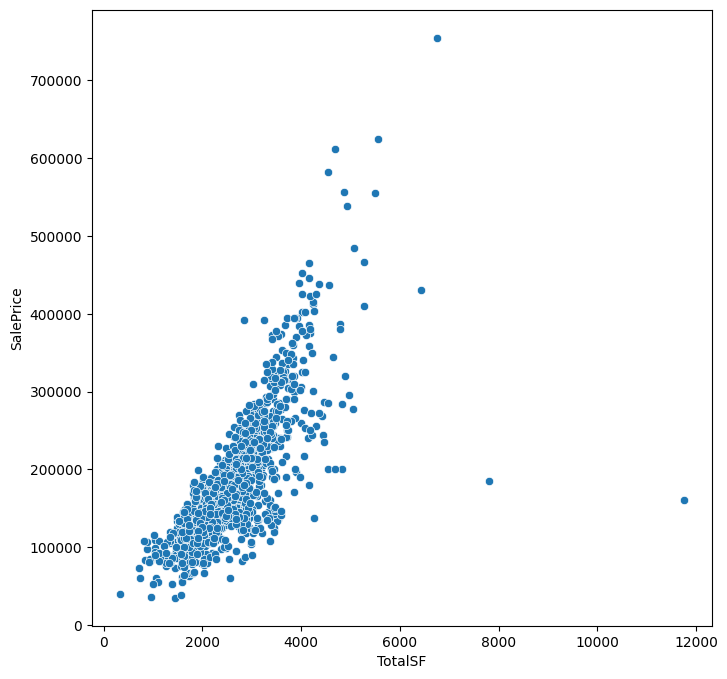

In [186]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='TotalSF', y='SalePrice')
plt.show()

In [187]:
# 이상치 제거
outlier_index = train[(train['SalePrice']<220000)&(train['TotalSF']>6000)]
train = train.drop(outlier_index.index).reset_index(drop=True)

> LotArea 이상치 제거

<Axes: ylabel='LotArea'>

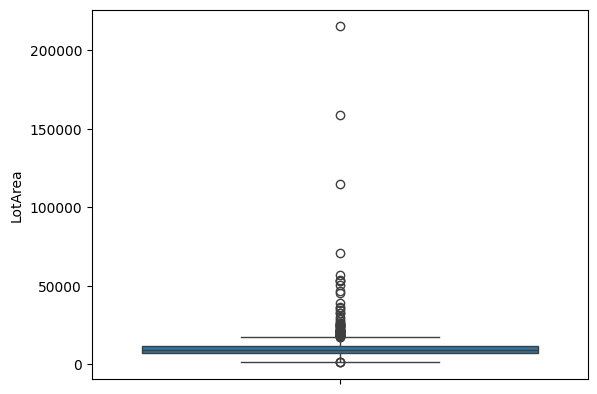

In [188]:
sns.boxplot(train['LotArea'])

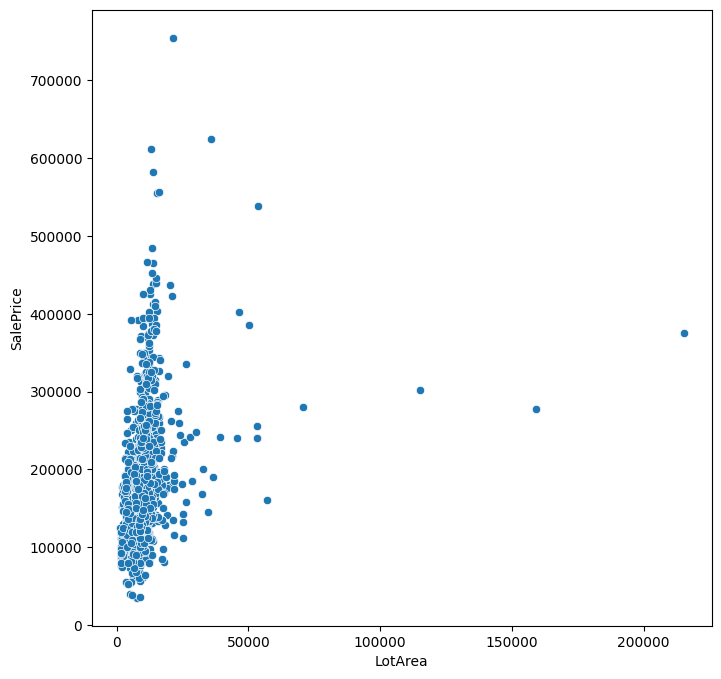

In [189]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='LotArea', y='SalePrice')
plt.show()

In [190]:
train[train['LotArea'] > 30000]

,LotArea,Street,LotConfig,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,SalePrice,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod
43,50271,Pave,Inside,9,5,1981,1842,0,1,5,1,Attchd,3,385000,1,3684,23,0,1,1
214,159000,Pave,CulDSac,6,7,1958,1444,4,1,7,2,Attchd,2,277000,2,3588,4,1,1,1
236,39104,Pave,CulDSac,7,7,1954,1385,2,1,5,2,Attchd,2,241500,1,2748,5,0,1,1
278,215245,Pave,Inside,7,5,1965,2136,3,1,8,2,Attchd,2,375000,2,4172,45,0,1,0
339,53107,Pave,Corner,6,5,1992,1580,3,1,9,2,Attchd,2,240000,3,3533,18,1,1,0
362,34650,Pave,Inside,5,5,1955,1056,3,1,5,0,Attchd,2,145000,1,2112,55,0,1,0
394,70761,Pave,Inside,7,5,1975,1533,2,1,5,2,Attchd,2,280000,2,3066,35,0,1,0
400,53227,Pave,CulDSac,4,6,1954,1364,2,1,6,2,Attchd,2,256000,1,3027,16,0,1,1
471,32668,Pave,CulDSac,6,3,1957,2035,4,2,9,2,Attchd,2,200624,3,4550,35,0,1,1
603,46589,Pave,CulDSac,8,7,1994,1629,4,1,8,1,Attchd,3,402000,3,4077,5,1,1,1


In [191]:
# LotArea 이상치 제거
train = train[train['LotArea'] < 30000].reset_index(drop=True)

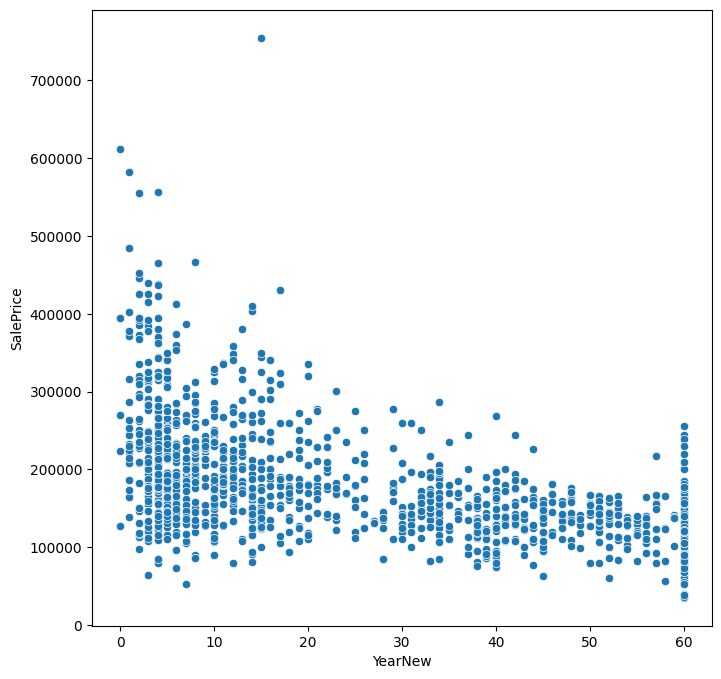

In [192]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='YearNew', y='SalePrice')
plt.show()

In [193]:
train[train['SalePrice']>500000]

,LotArea,Street,LotConfig,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,SalePrice,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod
377,15431,Pave,Inside,10,5,2008,3094,2,1,10,2,Attchd,3,555000,2,5496,2,0,1,0
623,21535,Pave,Corner,10,6,1994,2444,4,1,10,2,Attchd,3,755000,4,6760,15,1,1,1
728,13891,Pave,Inside,9,5,2008,1734,4,1,12,1,BuiltIn,3,582933,4,4556,1,1,1,1
822,12919,Pave,Inside,9,5,2009,2330,2,1,11,2,Attchd,3,611657,3,4694,0,0,1,1
970,16056,Pave,Inside,9,5,2005,1992,4,1,11,1,BuiltIn,3,556581,4,4860,4,1,1,1


In [194]:
# SalePrice 이상치 제거
train = train[train['SalePrice'] < 500000].reset_index(drop=True)

### Encoding

In [195]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [196]:
all_data = pd.concat([X_train, test], axis=0).reset_index(drop=True)

In [197]:
all_data

,LotArea,Street,LotConfig,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod
0,8450,Pave,Inside,7,5,2003,856,3,1,8,0,Attchd,2,3,2566,7,1,1,0
1,9600,Pave,FR2,6,8,1976,1262,3,1,6,1,Attchd,2,2,2524,34,0,1,0
2,11250,Pave,Inside,7,5,2001,920,3,1,6,1,Attchd,2,3,2706,8,1,1,1
3,9550,Pave,Corner,7,5,1915,756,3,1,7,1,Detchd,3,1,2473,40,1,1,1
4,14260,Pave,FR2,8,5,2000,1145,4,1,9,1,Attchd,3,3,3343,10,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,11478,Pave,Inside,8,5,2007,1704,3,1,7,1,Attchd,3,2,3408,2,0,1,1
1440,16321,Pave,CulDSac,5,6,1957,1484,2,1,6,2,Attchd,1,1,3084,13,0,1,1
1441,6324,Pave,Inside,4,6,1927,520,1,1,4,0,Detchd,1,1,1040,60,0,1,1
1442,8500,Pave,Inside,4,4,1920,649,3,1,6,0,Detchd,1,1,1966,60,1,1,1


In [198]:
cols = ['Street', 'LotConfig', 'GarageType']

# cols OHE
all_data = pd.get_dummies(all_data, columns=cols)

In [199]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

categorical = all_data.select_dtypes(include='object').columns

for feature in categorical:
    all_data[feature] = encoder.fit_transform(all_data[feature])

In [200]:
all_data

,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod,Street_Grvl,Street_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,8450,7,5,2003,856,3,1,8,0,2,3,2566,7,1,1,0,False,True,False,False,False,False,True,False,True,False,False,False,False
1,9600,6,8,1976,1262,3,1,6,1,2,2,2524,34,0,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False
2,11250,7,5,2001,920,3,1,6,1,2,3,2706,8,1,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
3,9550,7,5,1915,756,3,1,7,1,3,1,2473,40,1,1,1,False,True,True,False,False,False,False,False,False,False,False,False,True
4,14260,8,5,2000,1145,4,1,9,1,3,3,3343,10,1,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,11478,8,5,2007,1704,3,1,7,1,3,2,3408,2,0,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
1440,16321,5,6,1957,1484,2,1,6,2,1,1,3084,13,0,1,1,False,True,False,True,False,False,False,False,True,False,False,False,False
1441,6324,4,6,1927,520,1,1,4,0,1,1,1040,60,0,1,1,False,True,False,False,False,False,True,False,False,False,False,False,True
1442,8500,4,4,1920,649,3,1,6,0,1,1,1966,60,1,1,1,False,True,False,False,False,False,True,False,False,False,False,False,True


In [201]:
# 공통 전처리 끝
X_train = all_data.iloc[:len(X_train)]
test = all_data.iloc[len(X_train):].reset_index(drop=True)

In [202]:
X_train.shape, test.shape

((1314, 29), (130, 29))

In [203]:
X_train

,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod,Street_Grvl,Street_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,8450,7,5,2003,856,3,1,8,0,2,3,2566,7,1,1,0,False,True,False,False,False,False,True,False,True,False,False,False,False
1,9600,6,8,1976,1262,3,1,6,1,2,2,2524,34,0,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False
2,11250,7,5,2001,920,3,1,6,1,2,3,2706,8,1,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
3,9550,7,5,1915,756,3,1,7,1,3,1,2473,40,1,1,1,False,True,True,False,False,False,False,False,False,False,False,False,True
4,14260,8,5,2000,1145,4,1,9,1,3,3,3343,10,1,1,0,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,7917,6,5,1999,953,3,1,7,1,2,3,2600,10,1,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
1310,13175,6,6,1978,1542,3,1,7,2,2,2,3615,22,0,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
1311,9042,7,9,1941,1152,4,1,9,2,1,2,3492,4,1,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
1312,9717,5,6,1950,1078,2,1,5,0,1,1,2156,14,0,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False


In [204]:
test

,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalBath,TotalSF,YearNew,Has2ndFlr,HasBsmt,HasRemod,Street_Grvl,Street_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd
0,11200,5,5,1965,1040,3,1,5,0,1,1,2080,45,0,1,0,False,True,False,False,False,False,True,False,False,False,False,False,True
1,7200,5,7,1951,900,3,1,5,0,2,1,1800,10,0,1,1,False,True,True,False,False,False,False,False,False,False,False,False,True
2,16905,5,6,1959,1350,2,1,5,2,1,2,2678,51,0,1,0,False,True,False,False,False,False,True,False,True,False,False,False,False
3,9180,5,7,1983,840,2,1,5,0,2,1,1724,27,0,1,0,False,True,False,True,False,False,False,False,True,False,False,False,False
4,7200,5,7,1920,530,3,1,6,0,1,1,1641,14,1,1,1,False,True,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,11478,8,5,2007,1704,3,1,7,1,3,2,3408,2,0,1,1,False,True,False,False,False,False,True,False,True,False,False,False,False
126,16321,5,6,1957,1484,2,1,6,2,1,1,3084,13,0,1,1,False,True,False,True,False,False,False,False,True,False,False,False,False
127,6324,4,6,1927,520,1,1,4,0,1,1,1040,60,0,1,1,False,True,False,False,False,False,True,False,False,False,False,False,True
128,8500,4,4,1920,649,3,1,6,0,1,1,1966,60,1,1,1,False,True,False,False,False,False,True,False,False,False,False,False,True


# Model training

### XGBoost

In [205]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'min_child_weight': (1, 10),
    'reg_alpha': (0, 1),
    'reg_lambda': (0, 1),
    }

def eval_function(max_leaves, learning_rate, n_estimators, max_depth, min_child_weight, reg_alpha, reg_lambda):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
    }

    xgb_model = XGBRegressor(**params, random_state=42)
    score, mean_score = rmse_cv(xgb_model)
    return -mean_score

In [206]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | learni... | max_depth | max_le... | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
| 1         | -2.609e+0 | 0.1879    | 14.41     | 750.1     | 6.388     | 240.4     | 0.156     | 0.05808   |
| 2         | -2.697e+0 | 0.4332    | 10.21     | 725.7     | 1.185     | 972.9     | 0.8324    | 0.2123    |
| 3         | -2.486e+0 | 0.09173   | 5.201     | 312.9     | 5.723     | 488.8     | 0.2912    | 0.6119    |
| 4         | -2.489e+0 | 0.07061   | 6.506     | 376.4     | 5.105     | 806.7     | 0.1997    | 0.5142    |
| 5         | -2.453e+0 | 0.2966    | 3.557     | 622.9     | 2.535     | 158.5     | 0.9489    | 0.9656    |
| 6         | -2.451e+0 | 0.1372    | 3.489     | 309.2     | 8.005     | 494.9     | 0.2908    | 0.3048    |
| 7         | -2.464e+0 | 0.06148   | 7.369     | 623.2     | 4.167     | 165.8     | 0.8007    | 0.1581    |
| 8       

In [207]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'reg_alpha': optimizer.max['params']['reg_alpha'],
    'reg_lambda': optimizer.max['params']['reg_lambda'],
}

best_xgb = XGBRegressor(**best_params, random_state=42)
score, mean_score = rmse_cv(best_xgb)
print(score)
print(mean_score)

[23417.78180943 21595.38720796 21864.49216    26177.77315825
 27316.97920281 19650.32654362 18721.18315413 20469.09804107
 24115.26815122 25570.73388646]
22889.902331494664


In [208]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score

best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_train)

r2_score(y_pred, y_train)

0.9380169485653189

# 결과 제출

In [209]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [210]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test)

submission['SalePrice'] = xgb_pred
submission.to_csv('Case4_sub.csv', index=False)